In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV

In [2]:
# Loading the Data
raw_data = pd.read_csv('Fraud_check.csv')
raw_data.head()

,Undergrad,Marital.Status,Taxable.Income,City.Population,Work.Experience,Urban
0,NO,Single,68833,50047,10,YES
1,YES,Divorced,33700,134075,18,YES
2,NO,Married,36925,160205,30,YES
3,YES,Single,50190,193264,15,YES
4,NO,Married,81002,27533,28,NO


# EDA

In [3]:
df = raw_data.copy()
df.rename(columns = {'Undergrad':'undergrad', 'Marital.Status':'marital_status', 
                   'Taxable.Income':'tax_income', 'City.Population':'city_pop', 
                   'Work.Experience':'work_exp', 'Urban':'urban'}, inplace = True)
df.head()

,undergrad,marital_status,tax_income,city_pop,work_exp,urban
0,NO,Single,68833,50047,10,YES
1,YES,Divorced,33700,134075,18,YES
2,NO,Married,36925,160205,30,YES
3,YES,Single,50190,193264,15,YES
4,NO,Married,81002,27533,28,NO


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   undergrad       600 non-null    object
 1   marital_status  600 non-null    object
 2   tax_income      600 non-null    int64 
 3   city_pop        600 non-null    int64 
 4   work_exp        600 non-null    int64 
 5   urban           600 non-null    object
dtypes: int64(3), object(3)
memory usage: 28.2+ KB


No Null Values

In [5]:
def filt(x):
    if x <= 30000:
        return 'Risky'
    else:
        return 'Good'

In [6]:
df['fraud'] = df['tax_income'].copy()
df['fraud'] = df['fraud'].apply(filt)
df.head()

,undergrad,marital_status,tax_income,city_pop,work_exp,urban,fraud
0,NO,Single,68833,50047,10,YES,Good
1,YES,Divorced,33700,134075,18,YES,Good
2,NO,Married,36925,160205,30,YES,Good
3,YES,Single,50190,193264,15,YES,Good
4,NO,Married,81002,27533,28,NO,Good


In [7]:
df.fraud.value_counts()

Good     476
Risky    124
Name: fraud, dtype: int64

In [8]:
label_encoder = preprocessing.LabelEncoder()

df['undergrad']= label_encoder.fit_transform(df['undergrad']) 

df['urban']= label_encoder.fit_transform(df['urban']) 

df['marital_status']= label_encoder.fit_transform(df['marital_status']) 

df['fraud']= label_encoder.fit_transform(df['fraud'])

df.head()

,undergrad,marital_status,tax_income,city_pop,work_exp,urban,fraud
0,0,2,68833,50047,10,1,0
1,1,0,33700,134075,18,1,0
2,0,1,36925,160205,30,1,0
3,1,2,50190,193264,15,1,0
4,0,1,81002,27533,28,0,0


In [9]:
df.describe()

,undergrad,marital_status,tax_income,city_pop,work_exp,urban,fraud
count,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000
mean,0.520000,1.046667,55208.375000,108747.368333,15.558333,0.503333,0.206667
std,0.500017,0.821958,26204.827597,49850.075134,8.842147,0.500406,0.405252
min,0.000000,0.000000,10003.000000,25779.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,32871.500000,66966.750000,8.000000,0.000000,0.000000
50%,1.000000,1.000000,55074.500000,106493.500000,15.000000,1.000000,0.000000
75%,1.000000,2.000000,78611.750000,150114.250000,24.000000,1.000000,0.000000
max,1.000000,2.000000,99619.000000,199778.000000,30.000000,1.000000,1.000000


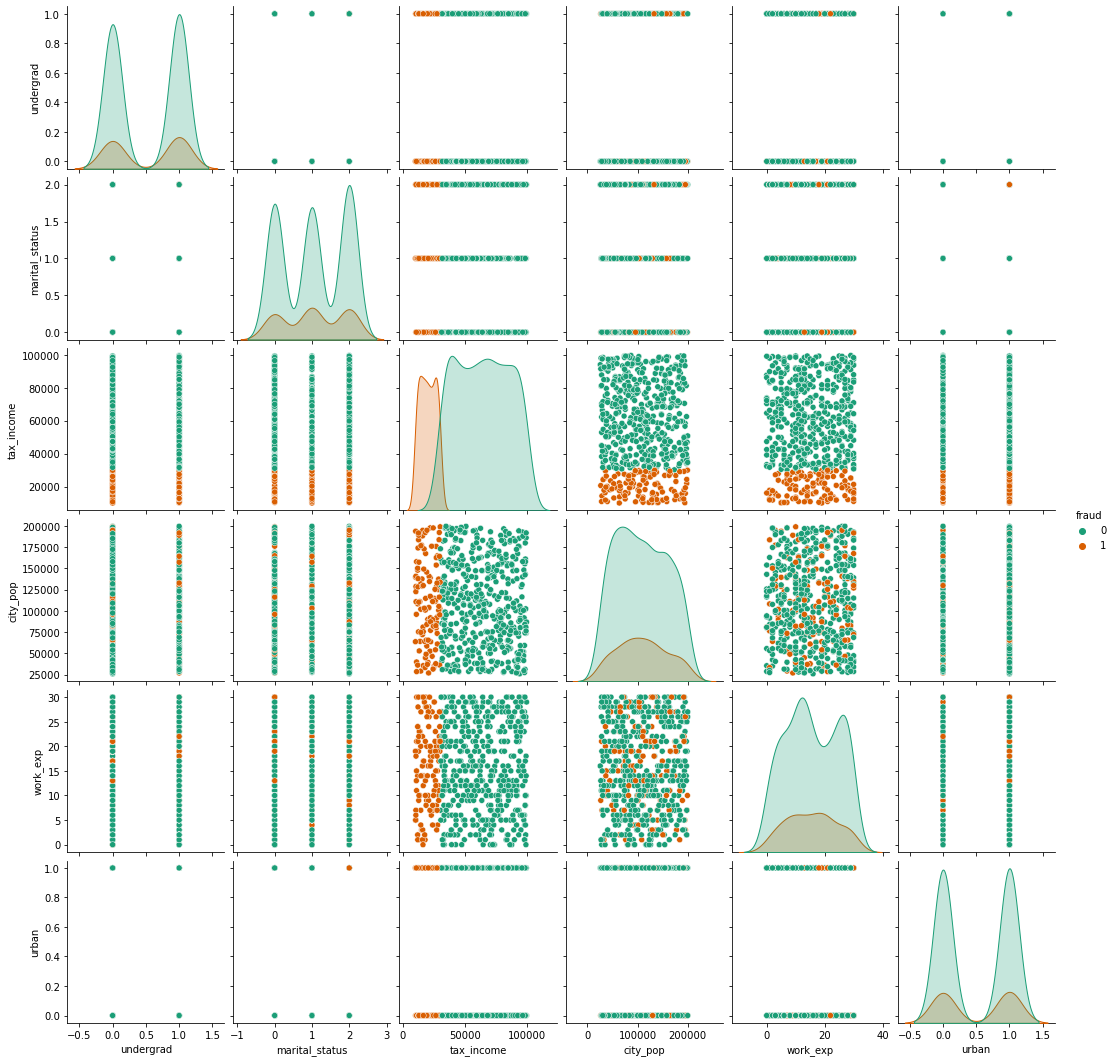

In [10]:
sns.pairplot(df, hue ='fraud', palette = 'Dark2');

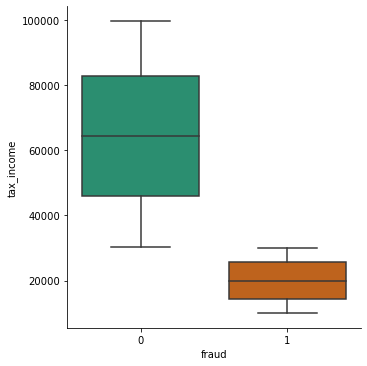

In [11]:
sns.catplot(x = 'fraud', y = 'tax_income', data = df, kind = 'box', palette = 'Dark2');

# Random Forest

In [12]:
X = df.iloc[:, :-1].values
y = df.fraud.values

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        95
           1       1.00      1.00      1.00        25

    accuracy                           1.00       120
   macro avg       1.00      1.00      1.00       120
weighted avg       1.00      1.00      1.00       120



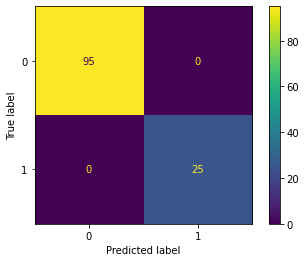

In [13]:
# Split the dataset into a training set and test set.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 101)

# Create the RandomForestClassifier object
rf = RandomForestClassifier(random_state = 101)

# Train the model
rf.fit(X_train, y_train)

rf_y_pred = rf.predict(X_test)

plot_confusion_matrix(rf, X_test, y_test);
print(classification_report(y_test,rf_y_pred))

This is very good but not sure if it's an overfitted model.

# Tuning the Random Forest

* Feature Importances

In [14]:
ft_imp = pd.Series(rf.feature_importances_, 
                   index = df.iloc[:, :-1].columns).sort_values(ascending = False)
ft_imp

tax_income        0.917852
city_pop          0.039304
work_exp          0.027476
marital_status    0.007456
urban             0.004000
undergrad         0.003912
dtype: float64

In [15]:
X_imp = df[['tax_income', 'city_pop', 'work_exp']].values

* Grid Search

In [16]:
n_estimators = list(range(5, 105, 5))

param_grid = {
    'n_estimators': n_estimators, # The number of trees
}

rf = RandomForestClassifier(random_state = 101)

gs = GridSearchCV(rf, param_grid, cv = 5)
gs.fit(X_imp, y)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=101),
             param_grid={'n_estimators': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50,
                                          55, 60, 65, 70, 75, 80, 85, 90, 95,
                                          100]})

* Elbow Graph

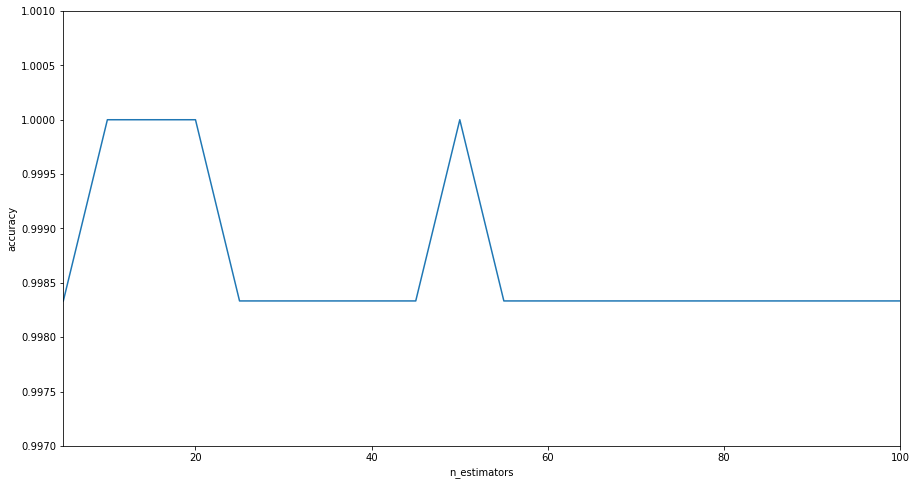

In [17]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

scores = gs.cv_results_['mean_test_score']
figure(figsize = (15, 8))
plt.plot(n_estimators, scores)
plt.xlabel("n_estimators")
plt.ylabel("accuracy")
plt.xlim(5, 100)
plt.ylim(0.997, 1.001)
plt.show()

# Final Model

              precision    recall  f1-score   support

           0       0.99      1.00      0.99        95
           1       1.00      0.96      0.98        25

    accuracy                           0.99       120
   macro avg       0.99      0.98      0.99       120
weighted avg       0.99      0.99      0.99       120



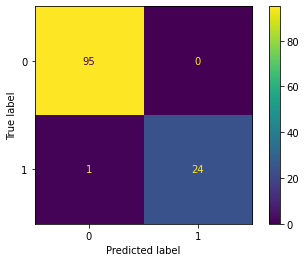

In [18]:
rf_final = RandomForestClassifier(random_state = 101, n_estimators = 10)

X_train, X_test, y_train, y_test = train_test_split(X_imp, y, test_size = 0.2, random_state = 101)
rf_final.fit(X_train, y_train)

rf_final_y_pred = rf_final.predict(X_test)
print(classification_report(y_test,rf_final_y_pred))
plot_confusion_matrix(rf_final, X_test, y_test);

# Visualizing Random Forest

In [19]:
from matplotlib import pyplot as plt
from sklearn.tree import plot_tree

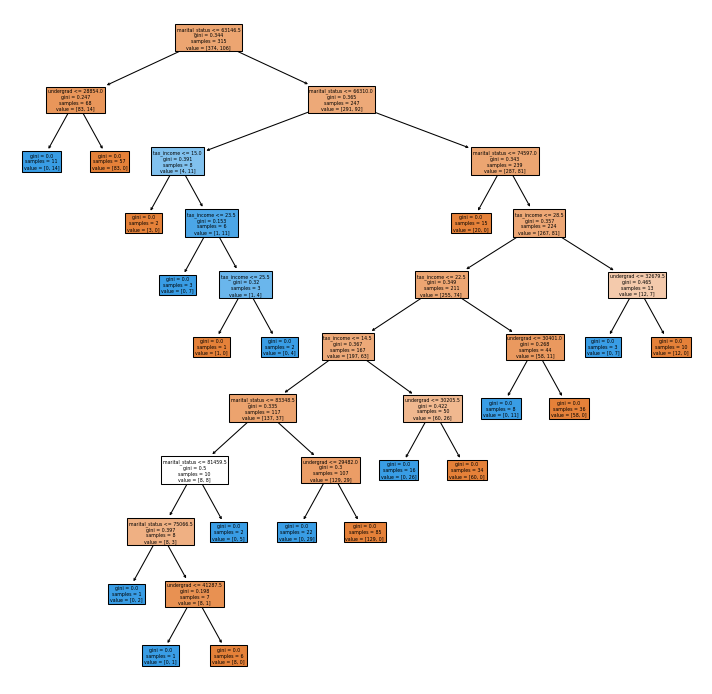

In [21]:
plt.figure(figsize = (12, 12), dpi = 75)
plot_tree(rf_final.estimators_[0], feature_names = df.iloc[:, :-1].columns, filled = True);

* Visualization of multiple trees used as estimator

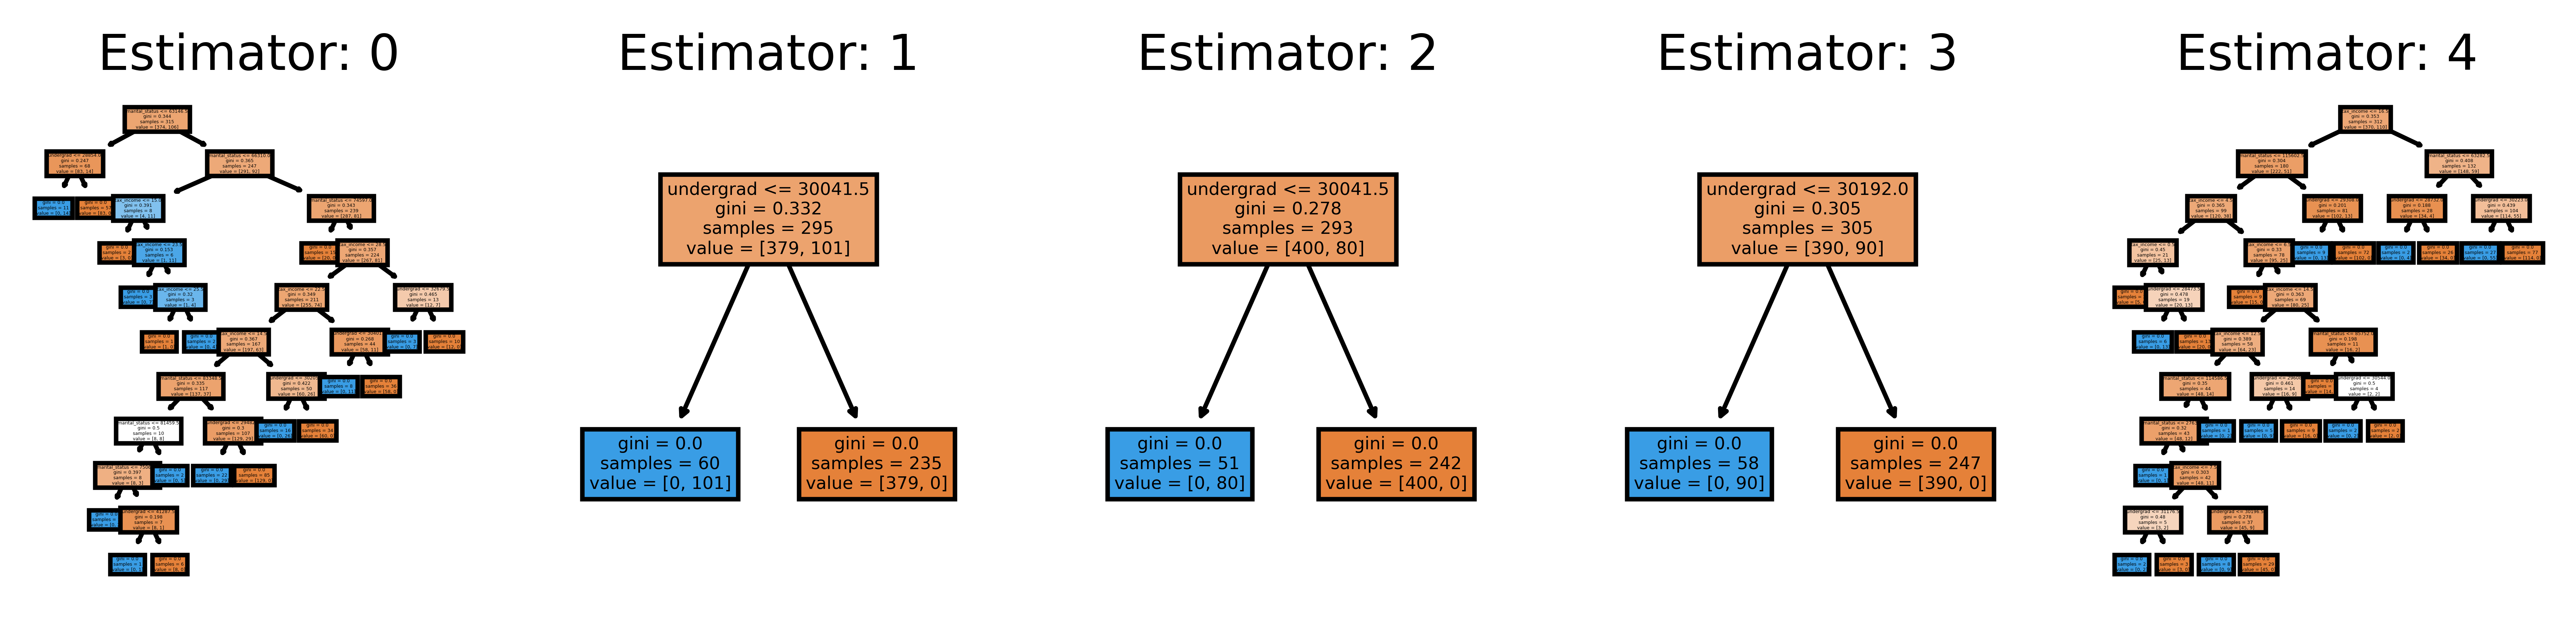

In [22]:
fig, axes = plt.subplots(nrows = 1, ncols = 5, figsize = (10,2), dpi = 900) 
for index in range(0, 5):
    plot_tree(rf_final.estimators_[index],
                   feature_names = df.iloc[:, :-1].columns,
                   filled = True,
                   ax = axes[index]);

    axes[index].set_title('Estimator: ' + str(index), fontsize = 11)